This example explains how to register 3D volumes using the Symmetric Normalization (SyN) algorithm proposed by Avants et al. [Avants09] (also implemented in the ANTs software [Avants11])

We will register two 3D volumes from the same modality using SyN with the Cross Correlation (CC) metric.

In [1]:
!pip install dipy

     |████████████████████████████████| 8.1MB 376kB/s 


In [2]:
!pip install fury

     |████████████████████████████████| 153kB 1.4MB/s 
     |████████████████████████████████| 48.9MB 57kB/s 


In [0]:
import numpy as np
from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
from dipy.align.imwarp import DiffeomorphicMap
from dipy.align.metrics import CCMetric
from dipy.core.gradients import gradient_table
from dipy.data import get_fnames
from dipy.io.image import load_nifti, save_nifti
from dipy.io.gradients import read_bvals_bvecs
import os.path
from dipy.viz import regtools

What is Symmetric Registration ?

A quality of image match is usually estimated by measuring image similarity. Unfortunately, similarity measures
assess only such transformations that change appearance of the deformed image, and in the case of non-rigid
registration the results of the similarity measurement depend on the registration direction. This asymmetric
relation leads to registration inconsistency and reduces the quality of registration. In this work we propose a
symmetric registration approach, which improves the registration by measuring similarity in both registration
directions. The solution presented in this paper is based on the interaction of both images involved in the registration process. Images interact with forces, which are according to the Newton’s action-reaction law forming
a symmetric relationship. These forces may transform both of the images, although in our implementation
one of the images remains fixed. The experiments performed to demonstrate the advantages of the symmetric
registration approach involve registration of simple objects, recovering synthetic deformation, and interpatient
registration of real images of head. The results show improvements of registration consistency and also indicate
the improvement of registration correctness.

Let’s fetch two b0 volumes, the first one will be the b0 from the Stanford HARDI dataset

In [4]:
hardi_fname, hardi_bval_fname, hardi_bvec_fname = get_fnames('stanford_hardi')

stanford_b0, stanford_b0_affine = load_nifti(hardi_fname)
stanford_b0 = np.squeeze(stanford_b0)[..., 0]

Download Progress: [########################################] 100.00%  of 0.00 MB

The second one will be the same b0 we used for the 2D registration tutorial

In [6]:
t1_fname, b0_fname = get_fnames('syn_data')
syn_b0, syn_b0_affine = load_nifti(b0_fname)


Download Progress: [########################################] 100.00%  of 1.34 MB

We first remove the skull from the b0’s

In [0]:
from dipy.segment.mask import median_otsu
stanford_b0_masked, stanford_b0_mask = median_otsu(stanford_b0,
                                                   median_radius=4,
                                                   numpass=4)
syn_b0_masked, syn_b0_mask = median_otsu(syn_b0, median_radius=4, numpass=4)

static = stanford_b0_masked
static_affine = stanford_b0_affine
moving = syn_b0_masked
moving_affine = syn_b0_affine

Suppose we have already done a linear registration to roughly align the two
images

In [0]:
pre_align = np.array([[1.02783543e+00, -4.83019053e-02, -6.07735639e-02, -2.57654118e+00],
                      [4.34051706e-03, 9.41918267e-01, -2.66525861e-01, 3.23579799e+01],
                      [5.34288908e-02, 2.90262026e-01, 9.80820307e-01, -1.46216651e+01],
                      [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

As we did in the 2D example, we would like to visualize (some slices of) the
two volumes by overlapping them over two channels of a color image. To do that
we need them to be sampled on the same grid, so let's first re-sample the
moving image on the static grid. We create an AffineMap to transform the moving
image towards the static image

In [0]:
from dipy.align.imaffine import AffineMap
affine_map = AffineMap(pre_align,
                       static.shape, static_affine,
                       moving.shape, moving_affine)

resampled = affine_map.transform(moving)

plot the overlapped middle slices of the volumes

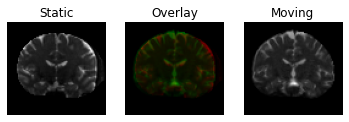

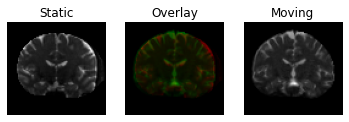

In [10]:
#Static image in red on top of the pre-aligned moving image (in green).
regtools.overlay_slices(static, resampled, None, 1, 'Static', 'Moving',
                        'input_3d.png')


We want to find an invertible map that transforms the moving image into the
static image. We will use the Cross-Correlation metric

In [0]:
metric = CCMetric(3)

Now we define an instance of the registration class. The SyN algorithm uses
a multi-resolution approach by building a Gaussian Pyramid. We instruct the
registration object to perform at most $[n_0, n_1, ..., n_k]$ iterations at
each level of the pyramid. The 0-th level corresponds to the finest resolution.

In [12]:
level_iters = [10, 10, 5]
sdr = SymmetricDiffeomorphicRegistration(metric, level_iters)

ERROR! Session/line number was not unique in database. History logging moved to new session 59


Execute the optimization, which returns a DiffeomorphicMap object,
that can be used to register images back and forth between the static and
moving domains. We provide the pre-aligning matrix that brings the moving
image closer to the static image

In [0]:
mapping = sdr.optimize(static, moving, static_affine, moving_affine, pre_align)

Now let's warp the moving image and see if it gets similar to the static image

In [0]:
warped_moving = mapping.transform(moving)

We plot the overlapped middle slices

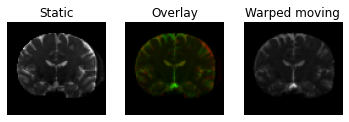

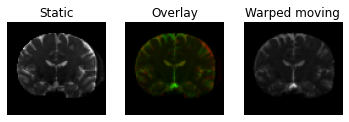

In [15]:
regtools.overlay_slices(static, warped_moving, None, 1, 'Static',
                        'Warped moving', 'warped_moving.png')

Static image transformed under the (inverse) transformation in red on top of
   the moving image (in green). Note that the moving image has a lower
   resolution.